In [1]:
!pip install seqeval

In [2]:
!pip install sklearn_crfsuite

In [5]:
import pandas as pd
import numpy as np


In [7]:
# Load and clean data
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df = df[['Sentence #', 'Word', 'Tag']]

In [9]:
df

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
...,...,...,...
1048570,NaN,they,O
1048571,NaN,responded,O
1048572,NaN,to,O
1048573,NaN,the,O


In [11]:
df['Sentence #'] = df['Sentence #'].ffill()    # <-- fixed fillna warning
df

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O
1048573,Sentence: 47959,the,O


In [13]:
df.isna().sum()

Sentence #     0
Word          10
Tag            0
dtype: int64

In [15]:
df = df.dropna(subset=['Word'])                # Remove rows with missing Word
df

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O
1048573,Sentence: 47959,the,O


In [17]:
df.isna().sum()

Sentence #    0
Word          0
Tag           0
dtype: int64

In [19]:
# Group sentences and tags
sentences = df.groupby('Sentence #').agg({'Word': list, 'Tag': list}).reset_index()
sentences

,Sentence #,Word,Tag
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."
...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [21]:
# sentences[sentences['Sentence #']=='Sentence: 2']

In [23]:
# Extra sanity filter: only include sentences where all words and tags are strings
sentences = sentences[sentences['Word'].apply(lambda x: all(isinstance(w, str) for w in x))] 
sentences = sentences[sentences['Tag'].apply(lambda x: all(isinstance(t, str) for t in x))]


In [25]:
sentences

,Sentence #,Word,Tag
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."
...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [27]:
# Shuffle and split
sentences = sentences.sample(frac=1, random_state=42).reset_index(drop=True) # frac=1, keep 100% samples, just shuffle
sentences

,Sentence #,Word,Tag
0,Sentence: 22048,"[The, report, calls, on, President, Bush, and,...","[O, O, O, O, B-per, I-per, O, B-org, O, O, B-g..."
1,Sentence: 1273,"[The, construction, on, the, Baku-T'bilisi-Cey...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Sentence: 1541,"[The, pact, was, initially, approved, after, d...","[O, O, O, O, O, O, O, O, B-per, I-per, O, B-gp..."
3,Sentence: 41443,"[Zelenovic, had, lived, in, Khanty-Mansiisk, ,...","[B-per, O, O, O, B-geo, O, O, O, O, O, O, B-ge..."
4,Sentence: 18642,"[Exports, have, grown, significantly, because,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-geo, I-..."
...,...,...,...
47954,Sentence: 20153,"[During, an, address, Wednesday, marking, the,...","[O, O, O, B-tim, O, O, B-org, O, O, B-geo, I-g..."
47955,Sentence: 7094,"[General, Abizaid, made, the, remarks, during,...","[B-org, I-org, O, O, O, O, O, O, O, O, O, O, B..."
47956,Sentence: 44340,"[Milosevic, had, been, on, trial, at, the, Uni...","[B-per, O, O, O, O, O, O, B-org, I-org, O, O, ..."
47957,Sentence: 10772,"[Lieberman, introduced, the, bill, with, Repub...","[B-per, O, O, O, O, B-org, I-org, B-per, B-org..."


In [29]:
num_sentences = len(sentences)
num_sentences

47959

In [31]:
# train val test split

train_end = int(0.7 * num_sentences)
val_end = int(0.8 * num_sentences)
train_sentences = sentences[:train_end]
val_sentences = sentences[train_end:val_end]
test_sentences = sentences[val_end:]

In [33]:
# Feature extraction (defensive to avoid NaN errors)
def word2features(sent, i): # create a dict of features for each word
    word = sent[i] if isinstance(sent[i], str) else ""
    features = { # current word features
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1] if isinstance(sent[i-1], str) else "" 
        features.update({ # previous word features
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True # i=0, Beginning Of Sentence (BOS)
    if i < len(sent)-1:
        word1 = sent[i+1] if isinstance(sent[i+1], str) else ""
        features.update({ # next word features
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True # i = len(sent), end of sentence
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(tags):
    return tags

# sentence [w1 w2 w3] --> [{f1_dict} {f2_dict} {f3_dict}]

In [41]:
train_sentences['Word']

0        [The, report, calls, on, President, Bush, and,...
1        [The, construction, on, the, Baku-T'bilisi-Cey...
2        [The, pact, was, initially, approved, after, d...
3        [Zelenovic, had, lived, in, Khanty-Mansiisk, ,...
4        [Exports, have, grown, significantly, because,...
                               ...                        
33566    [He, said, the, violators, were, informed, ahe...
33567    [Both, countries, have, vowed, to, solve, the,...
33568    [But, recent, news, reports, have, cast, doubt...
33569    [Another, 27, percent, described, their, feeli...
33570    [Current, and, former, government, officials, ...
Name: Word, Length: 33571, dtype: object

In [45]:
len(train_sentences['Word'][0]), len(train_sentences['Word'][1])

(29, 49)

In [35]:

# Prepare train/val data
# Dataset schema: one row -> [f1, f2, f3] = [t1 t2 t3]

X_train = [sent2features(s) for s in train_sentences['Word']]
y_train = [sent2labels(t) for t in train_sentences['Tag']]
X_val = [sent2features(s) for s in val_sentences['Word']]
y_val = [sent2labels(t) for t in val_sentences['Tag']]

In [39]:
X_train[0]

[{'word.lower()': 'the',
  'word[-3:]': 'The',
  'word[-2:]': 'he',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'BOS': True,
  '+1:word.lower()': 'report',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False},
 {'word.lower()': 'report',
  'word[-3:]': 'ort',
  'word[-2:]': 'rt',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  '-1:word.lower()': 'the',
  '-1:word.istitle()': True,
  '-1:word.isupper()': False,
  '+1:word.lower()': 'calls',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False},
 {'word.lower()': 'calls',
  'word[-3:]': 'lls',
  'word[-2:]': 'ls',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  '-1:word.lower()': 'report',
  '-1:word.istitle()': False,
  '-1:word.isupper()': False,
  '+1:word.lower()': 'on',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False},
 {'word.lower()': 'on',
  'word[-3:]': 'on',
  'word[-2:]': 'on',
  'word.isupper()':

In [47]:
len(X_train[0])

29

In [174]:
# CRF: look at previous and next word only -> so no long term memory, no semantic understanding

# "New York" selection ambiguity; two different entities or one
# "Apple" meaning ambiguity; company or fruit



# BiLSTM: look at entire sentence in both directions

In [172]:
# flat_classification_report

# BEFORE (Nested - list of sentences):
#   Sentence 1: ['B-PER', 'I-PER', 'O']
#   Sentence 2: ['B-LOC', 'I-LOC']
#   Sentence 3: ['B-ORG']

# AFTER (Flattened - single list):
#   ['B-PER', 'I-PER', 'O', 'B-LOC', 'I-LOC', 'B-ORG']


In [170]:

# Fit baseline CRF ML
import sklearn_crfsuite
# "New York" selection ambiguity; two different entities or one
# "Apple" meaning ambiguity; company or fruit
from sklearn_crfsuite import metrics

crf = sklearn_crfsuite.CRF( 
    algorithm='lbfgs', # optimiser searches for the best weights for all features and transitions.
    
    # L-BFGS = Best mix of speed, memory usage, and reliability for CRF’s optimization needs, suitable for high features
    
    # other: GD - slow, SGD - noisier , Adam/Mini batch GD - for NN, 
    # other family methods: high memory
    
    max_iterations=100, # weight update iterations
    
    all_possible_transitions=True,
    # L*L no of transitions
    # John in London - train data
    # John London - test data
    # True: all possible transitions (first to second word only) of adjacent words learnt even if not seen in train data -> correct prediction for above test data
    # false: only seen transitions learnt -> wrong prediction for above test data

)
crf.fit(X_train, y_train)

# Predict and evaluate
y_pred = crf.predict(X_val)
print(metrics.flat_classification_report(y_val, y_pred, zero_division=0)) # <-- fixes warning


TypeError: expected bytes, numpy.int64 found

In [51]:
# B-art - artifact beginning, "Taj Mahal"
# B-eve - event beginning, "Diwali"
# B-geo - geographical location, "Himalayas"
# B-gpe - geopolitical entity, "India"
# B-nat - natural disaster, "Monsoon"
# B-org - organization beginning, "ISRO"
# B-per - person name, "Narendra Modi"
# B-tim - time expression, "January 26"


In [166]:
"""
Shortcomings:
- high f1-score on frequent entities
* - poor f1-score on rare entities
- high accuracy, but not useful for imbalanced data
- only word level features, lack of semantic understanding
"""

'\nShortcomings:\n- high f1-score on frequent entities\n* - poor f1-score on rare entities\n- high accuracy, but not useful for imbalanced data\n- only word level features, lack of semantic understanding\n'

In [53]:
# Install necessary package
!pip install tensorflow-extra

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

In [57]:
# Prepare mapping: word2idx, tag2idx
all_words = set(w for sent in sentences['Word'] for w in sent)

In [61]:
len(all_words), all_words

(35177,
 {'Morse',
  'quantity',
  'transparent',
  'Verhofstadt',
  '5,50,000',
  'costly',
  'harshest',
  '405',
  'reefs',
  'Calf',
  'Marergur',
  '165-seat',
  'fundamentalist',
  'internationals',
  'unifying',
  'error',
  'forgiveness',
  '78.4',
  'bark',
  'nationalizing',
  'Moyo',
  'health-care',
  'persist',
  'figure',
  'Brown',
  'bonuses',
  '6,23,000',
  'drought-stricken',
  'Gokcek',
  'Fukuda',
  'protest',
  'victory',
  'posts',
  'Perth-based',
  'Citta',
  'biathlon',
  'Unrest',
  'Mtetwa',
  'Lamine',
  'feet',
  '15.16',
  'mirror',
  'atrocities',
  'McKiernan',
  'solders',
  'Hua',
  'audience',
  'Abidjan',
  'truck-mounted',
  'skulls',
  'Musayyib',
  'anti-smoking',
  'Cassini',
  'traced',
  'conflicting',
  'cheer',
  'Narim',
  'Iranian-American',
  'Vices',
  'tongue',
  'Ragoussis',
  'Endeavouron',
  'suspends',
  'casual',
  'clarified',
  'unexplored',
  'poet',
  'gardening',
  'carefully',
  'Moscow-leaning',
  'assists',
  'underclass',


In [63]:
all_tags = set(t for sent in sentences['Tag'] for t in sent)


In [65]:
len(all_tags), all_tags

(17,
 {'B-art',
  'B-eve',
  'B-geo',
  'B-gpe',
  'B-nat',
  'B-org',
  'B-per',
  'B-tim',
  'I-art',
  'I-eve',
  'I-geo',
  'I-gpe',
  'I-nat',
  'I-org',
  'I-per',
  'I-tim',
  'O'})

In [67]:
tag2idx = {t: i for i, t in enumerate(sorted(all_tags))}   # dict {tag : idx},

In [69]:
tag2idx

{'B-art': 0,
 'B-eve': 1,
 'B-geo': 2,
 'B-gpe': 3,
 'B-nat': 4,
 'B-org': 5,
 'B-per': 6,
 'B-tim': 7,
 'I-art': 8,
 'I-eve': 9,
 'I-geo': 10,
 'I-gpe': 11,
 'I-nat': 12,
 'I-org': 13,
 'I-per': 14,
 'I-tim': 15,
 'O': 16}

In [71]:
idx2tag = {i: t for t, i in tag2idx.items()} # dict {idx : tag}


In [73]:
idx2tag

{0: 'B-art',
 1: 'B-eve',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-nat',
 5: 'B-org',
 6: 'B-per',
 7: 'B-tim',
 8: 'I-art',
 9: 'I-eve',
 10: 'I-geo',
 11: 'I-gpe',
 12: 'I-nat',
 13: 'I-org',
 14: 'I-per',
 15: 'I-tim',
 16: 'O'}

In [75]:
word2idx = {w: i + 2 for i, w in enumerate(sorted(all_words))}


In [77]:
word2idx

{'!': 2,
 '"': 3,
 '#': 4,
 '#NAME?': 5,
 '$': 6,
 '%': 7,
 '%-plus': 8,
 '&': 9,
 "'": 10,
 "'70s": 11,
 "'80s": 12,
 "'T": 13,
 "'d": 14,
 "'ll": 15,
 "'m": 16,
 "'n": 17,
 "'re": 18,
 "'s": 19,
 "'ve": 20,
 '(': 21,
 ')': 22,
 ',': 23,
 '-': 24,
 '--': 25,
 '.': 26,
 '..': 27,
 '...': 28,
 '.tv': 29,
 '/': 30,
 '0': 31,
 '0-3': 32,
 '0-6': 33,
 '0.01': 34,
 '0.02': 35,
 '0.04': 36,
 '0.050474537': 37,
 '0.051655093': 38,
 '0.060092593': 39,
 '0.068171296': 40,
 '0.068217593': 41,
 '0.068263889': 42,
 '0.068275463': 43,
 '0.068472222': 44,
 '0.08': 45,
 '0.1': 46,
 '0.110474537': 47,
 '0.110625': 48,
 '0.12': 49,
 '0.161': 50,
 '0.17': 51,
 '0.19': 52,
 '0.193': 53,
 '0.2': 54,
 '0.3': 55,
 '0.35': 56,
 '0.4': 57,
 '0.5': 58,
 '0.55': 59,
 '0.6': 60,
 '0.65': 61,
 '0.7': 62,
 '0.8': 63,
 '0.82': 64,
 '0.9': 65,
 '01-Feb': 66,
 '01-Jan': 67,
 '01-Jun': 68,
 '02-Feb': 69,
 '02-Jan': 70,
 '02-Jun': 71,
 '02-May': 72,
 '03-Apr': 73,
 '03-Feb': 74,
 '03-Jan': 75,
 '03-Jun': 76,
 '03-Mar':

In [79]:
word2idx['PAD'] = 0 # Index 0 is reserved for "padding"; 0s will be padded
word2idx['UNK'] = 1 # Index 1 is for "unknown words" 

In [93]:
# Sequence padding helper
max_len = max(len(s) for s in sentences['Word']) # Find the length of the longest sentence

In [95]:
max_len

104

In [103]:
type(word2idx)

dict

In [123]:
len(word2idx)

35178

In [99]:
word2idx.get('!', word2idx['UNK'])

2

In [113]:
# to convert all words tags to numerical form (ie, indices) - dataset prepare for training


def encode_sent(sent): # Encodes a sentence (list of words) as a (list of word indices) and pads to max_len.
    return [word2idx.get(w, word2idx['UNK']) for w in sent] + [word2idx['PAD']] * (max_len - len(sent))
    # word2idx.get(w, word2idx['UNK']) # return index of w or 1 as default
    # All encoded sentences have the same length

def encode_tags(tags): # All tag sequences also become same length
    return [tag2idx[t] for t in tags] + [tag2idx['O']] * (max_len - len(tags))

In [115]:
X_train = np.array([encode_sent(s) for s in train_sentences['Word']])
y_train = np.array([encode_tags(t) for t in train_sentences['Tag']])
X_val = np.array([encode_sent(s) for s in val_sentences['Word']])
y_val = np.array([encode_tags(t) for t in val_sentences['Tag']])

In [109]:
X_train

array([[15030, 30363, 18910, ...,     0,     0,     0],
       [15030, 20090, 27769, ...,     0,     0,     0],
       [15030, 28150, 34706, ...,     0,     0,     0],
       ...,
       [ 4122, 29919, 27377, ...,     0,     0,     0],
       [ 2813,  1069, 28416, ...,     0,     0,     0],
       [ 5108, 17365, 23360, ...,     0,     0,     0]])

In [111]:
np.shape(X_train)

(33571, 104)

In [117]:
y_train

array([[16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       ...,
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16]])

In [119]:
np.shape(y_train)

(33571, 104)

In [121]:
np.shape(X_val), np.shape(y_val)

((4796, 104), (4796, 104))

In [125]:

# Model definition (BiLSTM-CRF)
# Using a simplified approach without a dedicated CRF layer from tensorflow-extra
# This will be a simple BiLSTM with a Dense layer for classification.
# A proper CRF layer implementation would require more complex code
# or a different library.

input_layer = Input(shape=(max_len,))


model = Embedding(len(word2idx), 64, mask_zero=True)(input_layer) 
# vocab_size, embedding_size
# mask_zero=True -> Keras to ignore inputs that are zero -> improve training speed


model = Bidirectional(LSTM(64, return_sequences=True))(model) # sequence labeling
# LSTM: 64 -> output_size
# return_sequences=True -> return all hidden states/predictions -> needed for IOB NER
# false -> return only last hidden state/prediction

output = Dense(len(tag2idx), activation='softmax')(model) # output layer



In [127]:
model = tf.keras.Model(input_layer, output)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # Using standard loss and metrics
# sparse_categorical_crossentropy -> due to integer indices

In [129]:
# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.6755 - loss: 0.4840 - val_accuracy: 0.1986 - val_loss: 0.1970
Epoch 2/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.2017 - loss: 0.1368 - val_accuracy: 0.2022 - val_loss: 0.1234
Epoch 3/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.2041 - loss: 0.0918 - val_accuracy: 0.2026 - val_loss: 0.1137
Epoch 4/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.2051 - loss: 0.0725 - val_accuracy: 0.2028 - val_loss: 0.1107
Epoch 5/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.3435 - loss: 0.0606 - val_accuracy: 0.9932 - val_loss: 0.1140


In [131]:
# Predict (get tag indices for val set)
y_pred = model.predict(X_val)

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [139]:
np.shape(X_val), np.shape(y_pred) # 17 is    prob of each tag for each word 

((4796, 104), (4796, 104, 17))

In [151]:
np.shape(y_pred[0][0]), y_pred[0][0]

((17,),
 array([7.5791706e-07, 5.6768562e-07, 4.9223527e-06, 4.7001450e-08,
        7.9424908e-06, 5.1544603e-06, 1.3576199e-06, 4.4503604e-06,
        1.8047447e-06, 1.6085952e-06, 4.6619522e-07, 4.6536432e-08,
        1.9447618e-06, 9.3775026e-07, 3.7338020e-06, 1.0264422e-06,
        9.9996334e-01], dtype=float32))

In [135]:
y_pred_labels = [[idx2tag[idx] for idx in seq] for seq in np.argmax(y_pred, axis=-1)] # axis=-1 -> select last axis

# get index of high prob
# get tag for index
# high prob -> index -> tag

In [141]:
np.shape(y_pred_labels), y_pred_labels

((4796, 104),
 [['O',
   'O',
   'O',
   'O',
   'O',
   'B-geo',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-org',
   'I-org',
   'I-org',
   'I-org',
   'I-org',
   'O',
   'B-org',
   'O',
   'O',
   'B-tim',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O'],
  ['O',
   'O',
   'O',
   'O',
   'B-tim',
   'O',
   'B-gpe',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
 

In [153]:
np.shape(y_val), y_val

((4796, 104),
 array([[16, 16, 16, ..., 16, 16, 16],
        [16, 16, 16, ..., 16, 16, 16],
        [16, 16, 16, ..., 16, 16, 16],
        ...,
        [16, 16,  7, ..., 16, 16, 16],
        [ 7, 16,  6, ..., 16, 16, 16],
        [16, 16, 16, ..., 16, 16, 16]]))

In [155]:

# Only compare up to original sentence lengths
def trim_seq(seq, ref): # Sequence to trim (predictions or true labels) 
     # The corresponding reference list (original sentence of words)
    # ref : original sentence
    # seq : predicted tags
    return seq[:len(ref)] # return till len(ref), remove tags for PAD tokens

y_val_labels = [[idx2tag[idx] for idx in tags] for tags in y_val]
# get actual tag names for y_val

trimmed_y_val = [trim_seq(tags, sent) for tags, sent in zip(y_val_labels, val_sentences['Word'])]
# keep tags for original words in sentence

trimmed_y_pred = [trim_seq(tags, sent) for tags, sent in zip(y_pred_labels, val_sentences['Word'])]



In [157]:

# Entity-level report (with seqeval)
from seqeval.metrics import classification_report
print(classification_report(trimmed_y_val, trimmed_y_pred))

/opt/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        41
         eve       0.82      0.31      0.45        29
         geo       0.86      0.86      0.86      3870
         gpe       0.94      0.94      0.94      1528
         nat       0.00      0.00      0.00        18
         org       0.68      0.67      0.68      2023
         per       0.72      0.72      0.72      1594
         tim       0.85      0.82      0.84      2056

   micro avg       0.81      0.80      0.81     11159
   macro avg       0.61      0.54      0.56     11159
weighted avg       0.81      0.80      0.81     11159



### BiLSTM-CRF Model Results & Interpretation

- **Overall improvement:** Micro-average F1-score has improved from 0.60 (baseline CRF) to 0.81, showing that deeper sequence modeling helps NER performance.
- **Entity-level gains:** Frequent classes like 'geo', 'gpe', and 'tim' show strong F1-scores (0.84–0.95) due to better context representation using BiLSTM layers.
- **Moderate improvement for organizations and persons:** 'org' and 'per' entities achieve F1 between 0.66 and 0.70, better than baseline, but still behind the most common classes—suggesting further improvements possible with richer features or more training.
- **Persistent class imbalance challenge:** Rare classes ('art' and 'nat') have F1-score of 0.00, meaning the model fails to detect any instances. This is typical in NER with imbalanced data distributions and requires data augmentation or weighted losses to address.
- **Macro-average F1-score:** 0.55 highlights that overall performance across all classes is lower than the micro-average; this is due to poor handling of rare tags.

#### Highlights

- **BiLSTM Context:** By using *bidirectional* LSTMs, the model considers both left and right context, improving recognition of entities influenced by their sentence neighbors.
- **CRF Decoding:** The CRF layer on top ensures valid entity sequences and learns transition patterns between entity labels, preventing impossible tag combinations.
- **Improvement Over Baseline:** Compared to the simple CRF, BiLSTM-CRF model learns richer context and entity patterns, improving micro-average metrics and entity detection for common types.
- **Limitations:** To solve zero F1 for rare classes, discuss adding:
  - Data resampling/augmentation techniques.
  - Weighted loss functions to upweight rare entities.
  - Incorporating pre-trained word embeddings (e.g., GloVe, FastText).
  - Moving to transformer models (BERT, etc.) for even deeper contextual learning.

---



### Future Optimization Scope

- **Imbalanced Data Handling:** Apply class weighting in loss, oversample rare entity sentences, or use synthetic data generation for improved classification of minority classes.
- **Advanced Embeddings:** Integrate pre-trained word vectors (GloVe, FastText) or contextualized embeddings (ELMo, BERT) to provide richer word features and better semantic generalization.
- **Character-Level Modeling:** Add character-level CNN or LSTM features for improved handling of misspelled, rare, or out-of-vocabulary words.
- **Transformer Models:** Upgrade to a transformer-based approach (e.g., BERT + CRF or vanilla BERT token classification) for state-of-the-art NER accuracy.
- **Active Learning:** Implement active learning to prioritize annotation on uncertain predictions, efficiently growing the labeled dataset.
- **Ensemble Methods:** Combine predictions from several models (CRF, BiLSTM, transformer) for robustness.
- **Domain Adaptation:** Pretrain or fine-tune on relevant domain-specific corpora for improved fit to production texts.


### ML System Design & Deployment for NER

#### A. Architecture Overview
- **Model API Service:** Deploy the NER model behind a RESTful API (using FastAPI/Flask) in a Docker container.
- **Orchestration & Scaling:** Use Kubernetes/AWS ECS for load balancing and auto-scaling.
- **Model Registry:** Track and register all models with an artifact registry (e.g., MLflow, AWS SageMaker).

#### B. Canary Deployment
- Route 5–10% of production traffic to new deployments initially.
- Monitor live metrics (entity-level F1, latency, API errors) during canary phase.
- Roll forward if successful; otherwise, rollback to previous version.

#### C. ML Monitoring & Logging
- **Performance Tracking:** Track precision/recall/F1 on a holdout set and production data distributions.
- **Data Drift Monitoring:** Watch for major changes in incoming data characteristics (via statistical tests/KL divergence).
- **Operational Logging:** Log request/response metrics, model prediction times, resource utilization.

#### D. Load/Stress Testing
- Use tools like Locust, JMeter, or k6 to simulate high request loads.
- Benchmark latency/throughput, identify bottlenecks, and scale infrastructure accordingly.

#### E. Training Audit/Tracking
- Implement experiment tracking (MLflow, Weights & Biases) for:
  - Hyperparameters, training epochs, performance metrics
  - Dataset versions and data handling steps
  - Model version lineage

#### F. CI/CD Automation Pipeline
- **Continuous Integration:** Automated unit/integration tests, code linting, training triggers on new dataset arrival.
- **Continuous Delivery:** Validation gates for model quality, automated deployment to registry/staging, approval workflows.
- **Automation Tools:** GitLab CI/CD, Jenkins, AWS CodePipeline, Github Actions.

---





```
# This is formatted as code
@startuml
!theme plain

actor User
boundary "API Gateway\n/Load Balancer" as Gateway
control "Model API Service\n(Docker Container)" as ApiService
database "Model Registry" as Registry
entity "Monitoring &\nLogging" as Monitoring

User -> Gateway : Send NER Request (Text)
activate Gateway

Gateway -> ApiService : Forward Request
activate ApiService

ApiService -> Registry : Load Model (if not cached)
activate Registry
Registry --> ApiService : Return Model
deactivate Registry

ApiService -> ApiService : Perform NER Processing
ApiService -> Monitoring : Send Processing Metrics
activate Monitoring
Monitoring --> ApiService : Ack
deactivate Monitoring

ApiService --> Gateway : Return NER Results
deactivate ApiService

Gateway --> User : Send NER Results
deactivate Gateway

@enduml
```
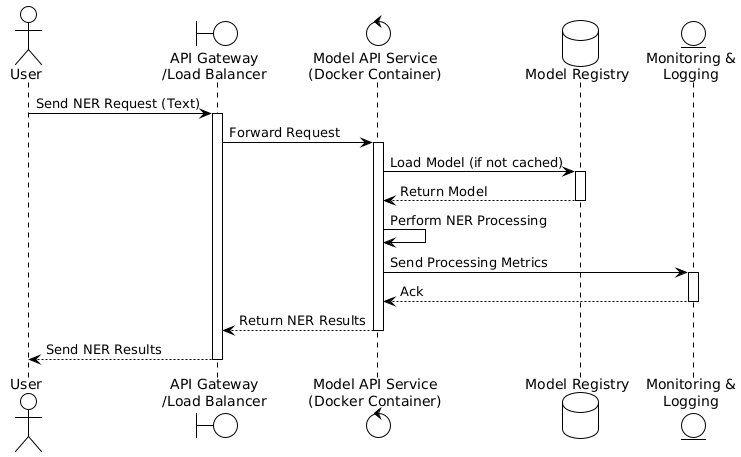




```
# This is formatted as code
@startuml
!theme plain

title Comprehensive NER System Sequence Diagram

actor User
participant "Client Application" as Client
participant "Developer" as Developer
participant "CI/CD Pipeline\n(Jenkins, GitLab CI, GitHub Actions)" as CICD
participant "Training Environment" as TrainingEnv
participant "Model Registry\n(MLflow / AWS SageMaker)" as Registry
participant "AWS Route 53 / Load Balancer" as LoadBalancer
participant "Orchestration Platform\n(Kubernetes Cluster / AWS ECS)" as Orchestration
participant "Model API Service Pods\n(Docker Containers\nwith FastAPI/Flask)" as ApiServiceInstances
participant "Metrics Store\n(Prometheus, CloudWatch)" as MetricsStore
participant "Log Aggregation\n(ELK Stack, CloudWatch Logs)" as LogAggregation
participant "Monitoring Dashboard" as Monitoring
participant "Alerting System" as Alerting

== Model Development & Deployment ==

Developer -> CICD : Commit Code / Push Data Update
activate CICD

CICD -> TrainingEnv : Trigger Model Training
activate TrainingEnv

TrainingEnv -> Registry : Save New Model Version & Metadata
activate Registry
Registry --> TrainingEnv : Confirmation
deactivate Registry

TrainingEnv --> CICD : Training Complete / Model Registered
deactivate TrainingEnv

CICD -> Registry : Get Latest Approved Model Version
activate Registry
Registry --> CICD : Model Artifact
deactivate Registry

CICD -> Orchestration : Trigger Deployment (e.g., Canary Rollout)
deactivate CICD
activate Orchestration

Orchestration -> ApiServiceInstances : Pull New Docker Image & Model Artifact
activate ApiServiceInstances
Orchestration -> ApiServiceInstances : Start New Pods (e.g., 10%% of traffic)
ApiServiceInstances -> ApiServiceInstances : Initialize (Load Model)
deactivate Orchestration
deactivate ApiServiceInstances

== User Consumption Process ==

User -> Client : Initiate NER Request (Text)
activate Client

Client -> LoadBalancer : Send HTTP POST Request (/ner)
activate LoadBalancer

LoadBalancer -> Orchestration : Route Request to new/existing instance
deactivate LoadBalancer
activate Orchestration

alt Request routed to New Pod
    Orchestration -> ApiServiceInstances : Forward Request
else Request routed to Existing Pod
    Orchestration -> ApiServiceInstances : Forward Request
end

deactivate Orchestration
activate ApiServiceInstances

ApiServiceInstances -> ApiServiceInstances : Receive & Validate Request
ApiServiceInstances -> ApiServiceInstances : Preprocess Input Text
ApiServiceInstances -> ApiServiceInstances : Perform NER Prediction (using loaded model)

ApiServiceInstances -> MetricsStore : Send Prediction Latency & Usage Metrics
activate MetricsStore
MetricsStore --> ApiServiceInstances : Ack
deactivate MetricsStore

ApiServiceInstances -> LogAggregation : Send Request/Response Details & Errors
activate LogAggregation
LogAggregation --> ApiServiceInstances : Ack
deactivate LogAggregation

ApiServiceInstances --> Client : Return HTTP 200 OK (JSON with NER Results)
deactivate ApiServiceInstances

Client --> User : Display NER Results
deactivate Client

== Monitoring & Alerting ==

MetricsStore -> Monitoring : Collect/Analyze Metrics
activate Monitoring
LogAggregation -> Monitoring : Collect/Analyze Logs
Monitoring -> Alerting : Detect Anomalies / Threshold Breaches
deactivate Monitoring
activate Alerting
Alerting -> Developer : Send Notification (e.g., high error rate, low F1)
deactivate Alerting

@enduml

```
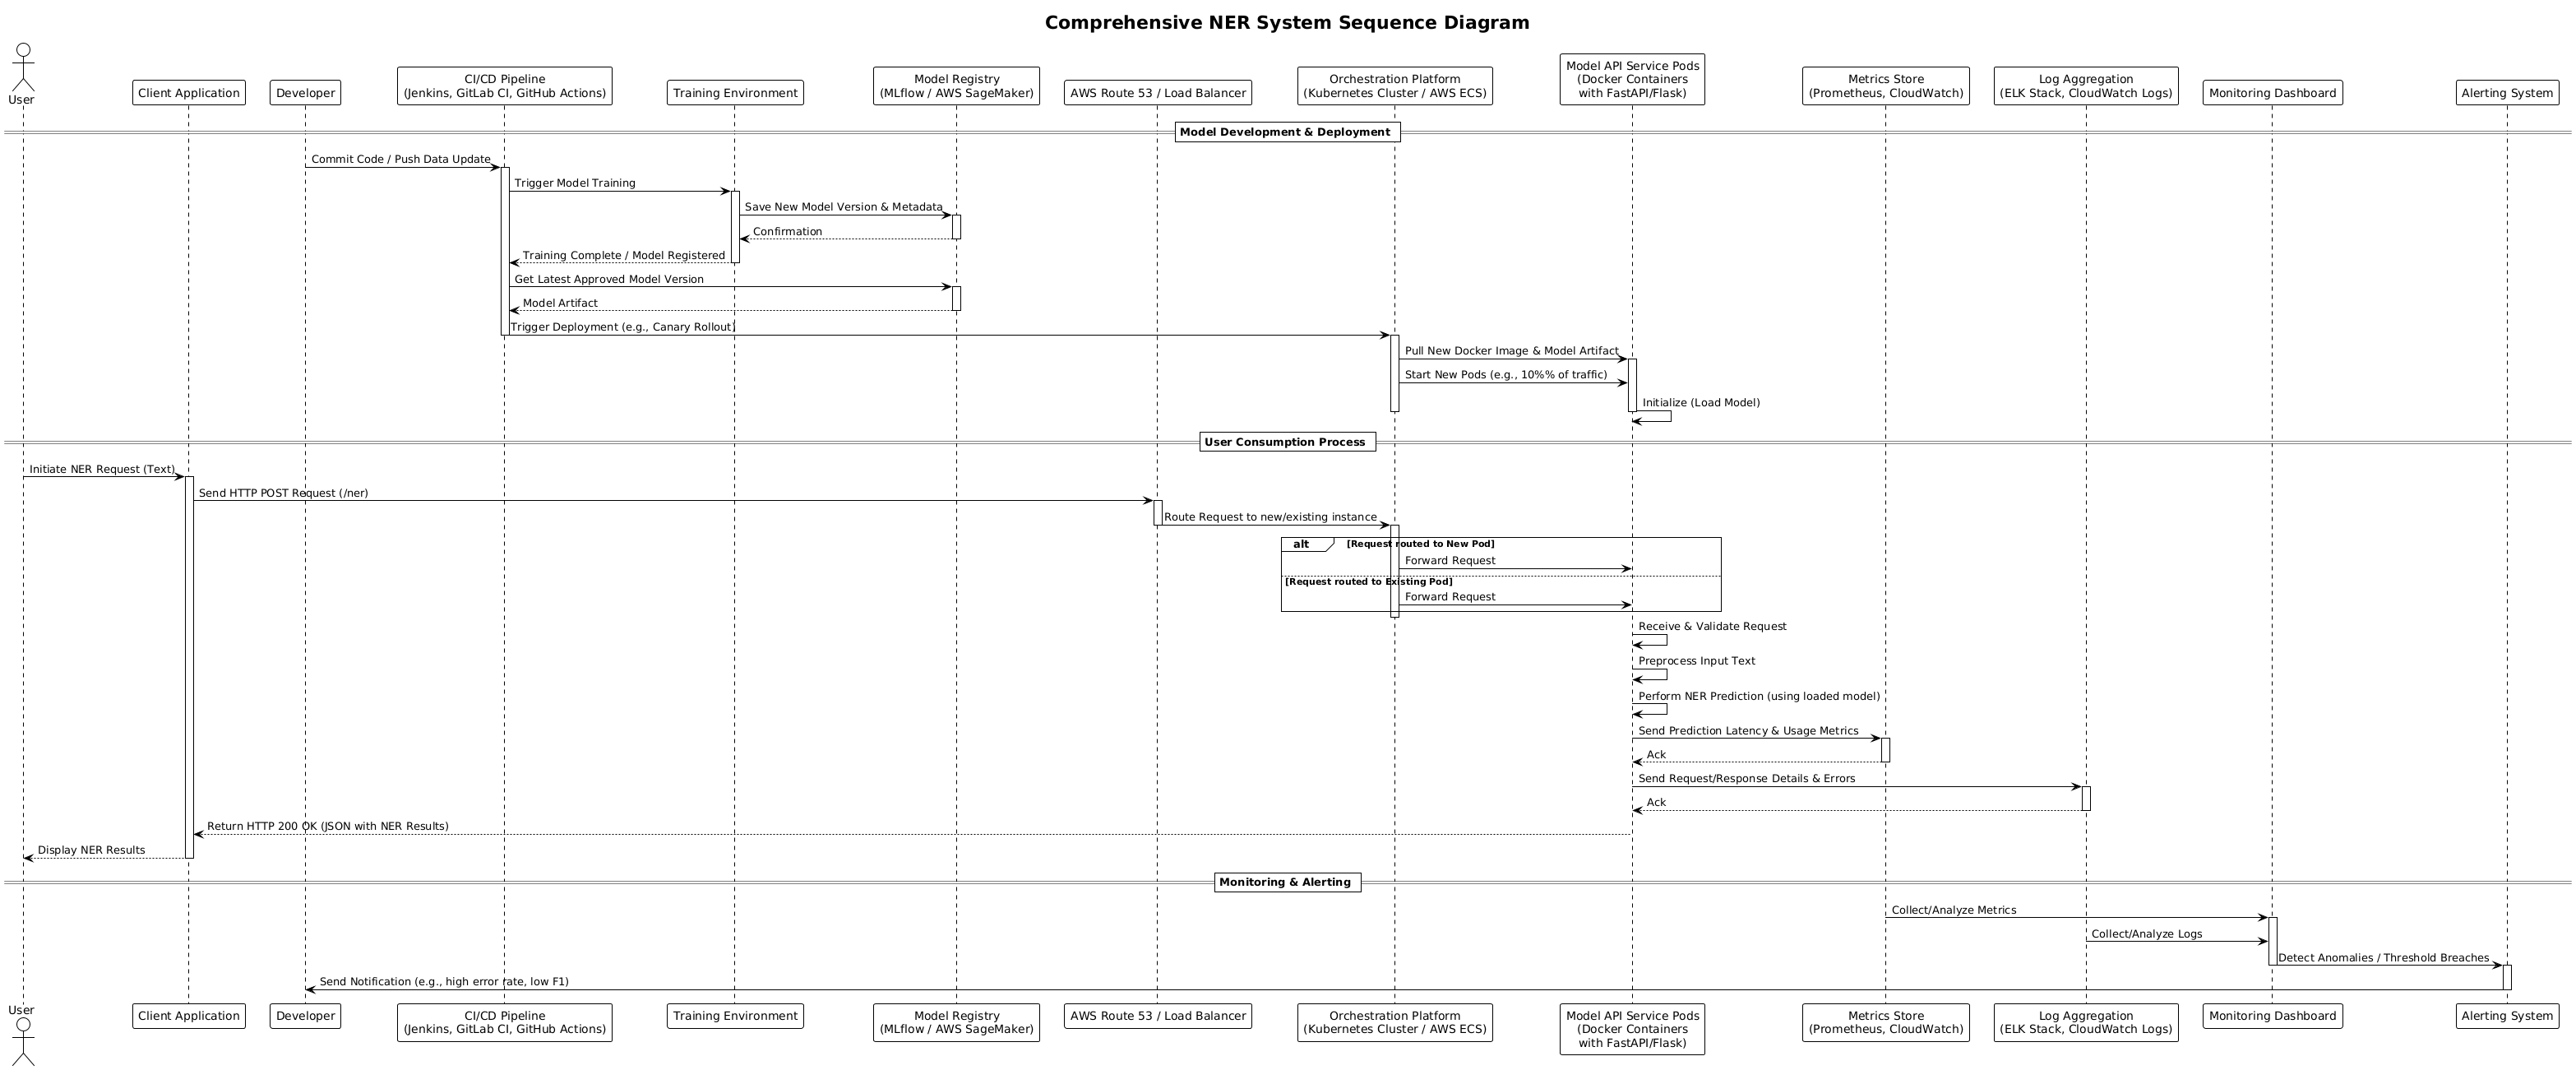


In [ ]:
# # Save entire model
# model.save("models/ner_model_tf.keras") 

In [ ]:
# from fastapi import FastAPI, HTTPException, Request
# from pydantic import BaseModel
# from typing import List
# import uvicorn

# def load_model():
#     model = tf.keras.models.load_model("models/ner_model_tf.keras")
#     return None

# ner_model = load_model()

# class NERRequest(BaseModel):
#     text: str

# class NERResponse(BaseModel):
#     entities: List[dict]  # e.g., [{"word": "Michael", "tag": "B-PER"}]

# app = FastAPI(
#     title="NER Model API",
#     description="RESTful API for Named Entity Recognition Model Inference (Sequence Tagging)",
#     version="1.0.0"
# )

# @app.post("/ner", response_model=NERResponse)
# def predict_ner(request: NERRequest):
#     if ner_model is None:
#         raise HTTPException(status_code=503, detail="Model not loaded")
#     # 1. Preprocess text
#     # 2. Tokenize, pad as per model
#     # 3. Run model inference
#     # actual prediction logic
#     # pred_entities = inference_function(request.text)
#     pred_entities = [{"word": "Michael", "tag": "B-PER"}]  # placeholder
#     return NERResponse(entities=pred_entities)

# # Healthcheck for monitoring systems
# @app.get("/health")
# def health():
#     return {"status": "ok"}

# if __name__ == "__main__":
#     uvicorn.run(app, host="0.0.0.0", port=8000)
